# Resizing an image
This reference design illustrates how to run a kernel for resizing an image on the FPGA.

## Hardware
A simplified block diagram is shown below:

![](./images/resize_bd.png)

## Software
The software enables users to run the kernel on the fpga and display the results in the notebook.

### Step 1: Import libraries

In [1]:
from PIL import Image
from matplotlib import pyplot
import numpy as np
from pynq import Xlnk
from pynq import Overlay
from IPython.display import display, Markdown


### Step 2. Download the *Resize IP* bitstream

In [2]:
resizer = Overlay("/opt/python3.6/lib/python3.6/site-packages/pynq/overlays/resize/resize.bit") 
dma = resizer.axi_dma_0
kernel = resizer.resize_accel_0

### Step 3: View image that is to be re-sized
The picture pixel data can be read using `PIL` library.


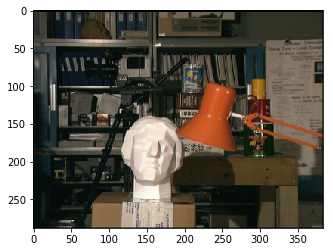

<h1 style="color:DeepPink"> Image size: 288x384 pixels.</h1>

In [3]:
image_path = "./images/img_l.png"
original_image = Image.open(image_path)
original_array = np.array(original_image)
original_image.close()

pyplot.imshow(original_array, interpolation='nearest')
pyplot.show()

old_width, old_height = original_image.size

def printmd(string):
    display(Markdown('<h1 style="color:DeepPink"> {}</h1>'.format(string)))
    
printmd("Image size: {}x{} pixels.".format(old_height, old_width))

### Step 4: Resize in software 
Image is resized by using the PIL `resize()` method. Image is scaled down by dividing width and height by 2   
**Note: The software example you will notice is quite slow**

In [4]:
new_width, new_height = int(old_width/2), int(old_height/2)
original_image = Image.open(image_path)

%timeit resized_image = original_image.resize((new_width, new_height), Image.ANTIALIAS)

31.4 ms ± 9.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Display image resized in SW

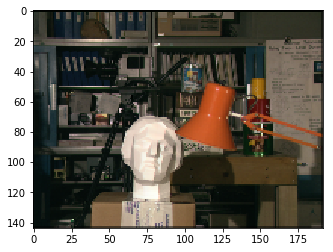

<h1 style="color:DeepPink"> Resized in Software(PS): 144x192 pixels.</h1>

In [5]:
resized_image = original_image.resize((new_width, new_height))

orig_image_array = np.array(original_image)
resized_array = np.array(resized_image)
original_image.close()

pyplot.imshow(resized_array, interpolation='nearest')
pyplot.show()
    
width, height = resized_image.size
printmd("Resized in Software(PS): {}x{} pixels.".format(height, width))

### Step 5: Allocating memory to process data on PL
Data is provided through contiguous memory locations.

The size of the buffer depends on the size of the input or output data.
The image dimensions extracted from the read image are used to allocate contiguous memory as follows.
We will use `cma_array` of the corresponding size.

In [6]:
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(old_height, old_width, 3), dtype=np.uint8)
out_buffer = xlnk.cma_array(shape=(new_height, new_width, 3), dtype=np.uint8)

__Note: In the following example, we are only dealing with one image. We will just send one image to the kernel and obtain the results.__

__Also Note: The `orig_image_array` has to be copied into the contiguous memory array(deep copy).__

#### Display the image in buffer

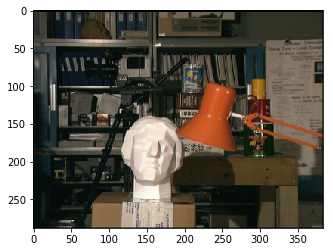

<h1 style="color:DeepPink"> Image size: 288x384 pixels.</h1>

In [7]:
in_buffer[:] = orig_image_array

pyplot.imshow(in_buffer)
pyplot.show()

printmd("Image size: {}x{} pixels.".format(old_height, old_width))


### Step 6:  Resize in hardware and display image
Now we will push the data from input buffer through the pipeline to the output buffer.   
Providing scalar inputs and running the kernel

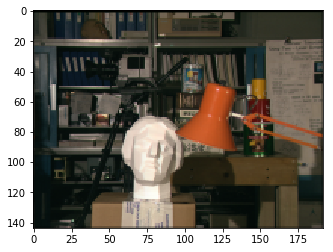

<h1 style="color:DeepPink"> Resized in Hardware(PL): 144x192 pixels.</h1>

In [8]:
kernel.write(0x10, old_height) # src rows
kernel.write(0x18, old_width)  # src cols
kernel.write(0x20, new_height) # dst rows
kernel.write(0x28, new_width)  # dst cols

def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    kernel.write(0x00,0x81)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

run_kernel()

pyplot.imshow(out_buffer)
pyplot.show()

printmd("Resized in Hardware(PL): {}x{} pixels.".format(new_height, new_width))

### Step 7: Time profile resize in HW

In [9]:
kernel.write(0x10, old_height) # src rows
kernel.write(0x18, old_width)  # src cols
kernel.write(0x20, new_height) # dst rows
kernel.write(0x28, new_width)  # dst cols

def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    kernel.write(0x00,0x81)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

%timeit run_kernel()

2.1 ms ± 2.38 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Reset Xlnk

In [10]:
xlnk.xlnk_reset()